# Marijuana Legalization and Violent Crime
Yuanjing Zhu & Emmanuel Ruhamyankaka

In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Exercise 1
Load the dataset

In [2]:
df = pd.read_csv("https://github.com/nickeubank/MIDS_Data/"
                 "blob/master/UDS_arrest_data.csv?raw=true")
df.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population
0,1980,Alameda County,4504,3569,1105379.0
1,1981,Alameda County,4699,3926,1122759.3
2,1982,Alameda County,4389,4436,1140139.6
3,1983,Alameda County,4500,5086,1157519.9
4,1984,Alameda County,3714,5878,1174900.2


In [3]:
print(f"Time period: {df['YEAR'].min()} - {df['YEAR'].max()}")

Time period: 1980 - 2018


- A single row represent a county in California in a given year.
- The entities being tracked are counties in California.
- The time period is from 1980 to 2018.

### Exercise 2

Calculate each county’s average drug arrest rate for the period from 2007-2009. 

In [12]:
df_2007_2009 = df.loc[df.loc[:,'YEAR'].isin([2007, 2008, 2009]), :]
df_2007_2009.loc[:,'drug arrest rate'] = df_2007_2009.loc[:,'F_DRUGOFF'] \
    / (df_2007_2009.loc[:,'total_population']/100000)
avg_drug_arrest_rate = df_2007_2009.groupby('COUNTY')['drug arrest rate'].mean()\
    .sort_values(ascending=False).to_frame()
avg_drug_arrest_rate.head()

,drug arrest rate
COUNTY,
San Francisco County,873.961738
Mendocino County,599.799767
Tehama County,585.300555
Humboldt County,499.572904
Plumas County,492.429787


Calculate the median value across counties

In [13]:
median_avg_ = avg_drug_arrest_rate.median().values[0]
print(f"The median value of average durg arrest rate across the counties is:\
      {median_avg_/100000*100:.2f}%")

The median value of average durg arrest rate across the counties is: 0.30%


Create an indicator called treated for counties with above-median average drug arrest rates during this period.

In [14]:
avg_drug_arrest_rate['indicator'] = np.where(avg_drug_arrest_rate['drug arrest rate']\
                                             > median_avg_, 1, 0)
avg_drug_arrest_rate.head()

,drug arrest rate,indicator
COUNTY,,
San Francisco County,873.961738,1
Mendocino County,599.799767,1
Tehama County,585.300555,1
Humboldt County,499.572904,1
Plumas County,492.429787,1


In [52]:
# make sure the indicator works as expected
assert avg_drug_arrest_rate.indicator.sum() == avg_drug_arrest_rate.shape[0] / 2, \
    "The indicator is not working as expected"

### Exercise 3
Create a violent_rate variable with is violent arrests per 100,000 people.

In [15]:
df['violent_rate'] = df['VIOLENT'] / df['total_population'] * 100000
df.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate
0,1980,Alameda County,4504,3569,1105379.0,407.462056
1,1981,Alameda County,4699,3926,1122759.3,418.522474
2,1982,Alameda County,4389,4436,1140139.6,384.952860
3,1983,Alameda County,4500,5086,1157519.9,388.762215
4,1984,Alameda County,3714,5878,1174900.2,316.111956


### Exercise 4
Difference-in-differences analysis

In [16]:
# merge the two dataframes
df_new = pd.merge(df, avg_drug_arrest_rate, left_on='COUNTY', right_index=True,\
                  indicator=True, how='outer',validate='m:1')
assert (df_new._merge == "both").all()# check that the merge was successful
df_new = df_new.drop(columns=['_merge'])

# add an indicator for post_2010 on the original dataframe, to be used in exercise 5
df_new['post_2010'] = np.where(df_new['YEAR'] >= 2010, 1, 0)
df_new.head()

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate,drug arrest rate,indicator,post_2010
0,1980,Alameda County,4504,3569,1105379.0,407.462056,394.457331,1,0
1,1981,Alameda County,4699,3926,1122759.3,418.522474,394.457331,1,0
2,1982,Alameda County,4389,4436,1140139.6,384.952860,394.457331,1,0
3,1983,Alameda County,4500,5086,1157519.9,388.762215,394.457331,1,0
4,1984,Alameda County,3714,5878,1174900.2,316.111956,394.457331,1,0


In [17]:
years_to_keep = [2007, 2008, 2009, 2016, 2017, 2018]
# subset to only inclde the years we want to keep
df_new_sub = df_new.loc[df_new['YEAR'].isin(years_to_keep), :]
treatment = df_new_sub.loc[df_new_sub['indicator'] == 1, :]
control = df_new_sub.loc[df_new_sub['indicator'] == 0, :]

 (a) Calculating the change in violent arrest rates for our treated groups from before legalization to after

In [18]:
change_for_treated = treatment.loc[treatment['YEAR'] > 2009, 'violent_rate'].mean()\
      - treatment.loc[treatment['YEAR'] < 2010, 'violent_rate'].mean()
print(f"The change in violent crime rate for treated counties is:\
       {change_for_treated:.2f}")

The change in violent crime rate for treated counties is: -26.80


(b) Calculating difference in difference estimator

In [20]:
change_for_control = control.loc[control['YEAR'] > 2009, 'violent_rate'].mean() \
    - control.loc[control['YEAR'] < 2010, 'violent_rate'].mean()
print(f"The change in violent crime rate for control counties is: \
      {change_for_control:.2f}")

The change in violent crime rate for control counties is: -19.38


In [21]:
diff_in_diff = change_for_treated - change_for_control
print(f"The Diff in Diff is: {diff_in_diff:.2f}")

The Diff in Diff is: -7.42


- From pre-post analysis of the treatment group, we can see that the violent rate has decreased by 26.8 (per 100,000 people) after legalization, indicating that the legalization of marijuana is effective.
- Results from Difference-in-difference analysis indicate that there was a decrease in violent crime rates in both the treated and control counties, but the decrease was greater in the treated counties. Specifically, the decrease in violent rate (per 100,000 people) of the treated counties was 7.42 percentage points greater than the decrease in the control counties, suggesting the legalization of marijuana has a positive effect on reducing violent crime rates. 

### Exercise 5
regressing violent rate on treated, post, and the interaction

In [22]:
import statsmodels.formula.api as smf

model = smf.ols(formula='violent_rate ~ indicator*post_2010', data=df_new_sub).fit()
model.get_robustcov_results(cov_type='cluster', groups=df_new_sub['COUNTY']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     11.00
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           8.45e-06
Time:                        20:34:05   Log-Likelihood:                -2094.1
No. Observations:                 348   AIC:                             4196.
Df Residuals:                     344   BIC:                             4212.
Df Model:                           3                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             319.7820     17.638     18.131      0.000     284.463     355.101
indicator             106.8289     23.385      4.568      0.000      60.001     153.657
post_2010             -19.3816      9.892     -1.959      0.055     -39.189       0.426
indicator:post_2010    -7.4181     18.869     -0.393      0.696     -45.203      30.367
==============================================================================
Omnibus:                       53.945   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.621
Skew:                           0.965   Prob(JB):                     1.89e-18
Kurtosis:                       4.380   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

- The coefficient on the interaction term is 7.42, which is the same as the difference-in-difference estimator we calculated in Exercise 4. This suggests that holding all other variables constant, the decrease in violent rate of treated coutries between pre and post legalization is 7.42 percentage points greater than the decrease in violent rate of control counties between pre and post legalization.
- However, the p-value of the interaction term is 0.696 (>0.05), indicating it is not statistically significant. This suggests that the difference-in-difference could be due to chance.

### Exercise 6
plot a difference in difference model

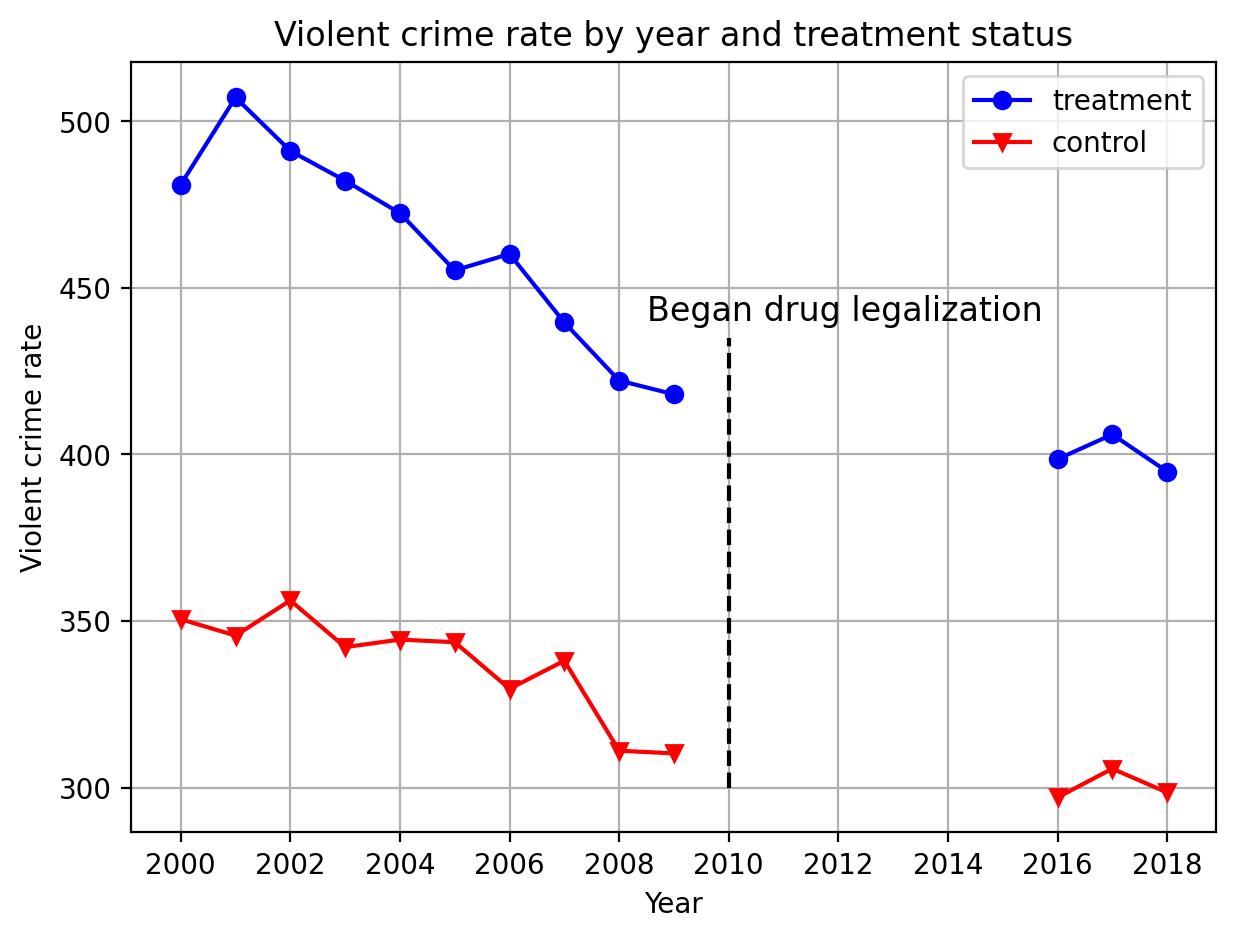

In [48]:
df_pre = df_new.loc[(df_new['YEAR']>=2000)&(df_new['YEAR']<=2009), :]
df_post = df_new.loc[(df_new['YEAR'].isin([2016, 2017, 2018])), :]
# prepare data for plotting
treatment_pre_plt = df_pre.loc[df_pre['indicator']==1, :].\
    groupby('YEAR')['violent_rate'].mean()
treatment_post_plt = df_post.loc[df_post['indicator']==1, :].\
    groupby('YEAR')['violent_rate'].mean()
control_pre_plt = df_pre.loc[df_pre['indicator']==0, :].\
    groupby('YEAR')['violent_rate'].mean()
control_post_plt = df_post.loc[df_post['indicator']==0, :].\
    groupby('YEAR')['violent_rate'].mean()

# start plotting
plt.figure(figsize=(7,5))
plt.grid('on')
plt.plot(treatment_pre_plt.index, treatment_pre_plt.values,\
          marker='o', label='treatment', c='blue')
plt.plot(treatment_post_plt.index, treatment_post_plt.values,\
          marker='o', c='blue')
plt.plot(control_pre_plt.index, control_pre_plt.values, marker='v', \
         label='control', c='red')
plt.plot(control_post_plt.index, control_post_plt.values, marker='v', \
         c='red')
plt.vlines(2010, 300, 435, linestyles='dashed', colors='black')
plt.xticks(np.arange(2000, 2020, 2))
plt.text(2008.5, 440, 'Began drug legalization', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Violent crime rate')
plt.title('Violent crime rate by year and treatment status')
plt.legend()
plt.show()

Yes, there is parallel trend for these two datasets. This might impair the validity of the difference-in-difference estimator since both the treated and control counties are experiencing a decrease in violent rate, suggesting that there might be some other reasons that cause the decrease in violent rate instead of the legalization of marijuana.

### Exercise 7
running the regression with county and year as fixed effects

In [49]:
from linearmodels import PanelOLS
df_new_multiindex = df_new_sub.set_index(['COUNTY', 'YEAR'])
mod = PanelOLS.from_formula('violent_rate ~ indicator*post_2010 '
                            '+ TimeEffects + EntityEffects',
                            data=df_new_multiindex,drop_absorbed=True).fit()
mod.summary


Dep. Variable:,violent_rate,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0109
No. Observations:,348,R-squared (Within):,0.0155
Date:,"Mon, Mar 06 2023",R-squared (Overall):,-0.0104
Time:,20:44:30,Log-likelihood,-1858.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.3829
Entities:,58,P-value,0.5366
Avg Obs:,6.0000,Distribution:,"F(1,284)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,0.3829


- With all the additional fixed effects, there is no concrete evidence that marijuana legalization reduced violent crime. 
- Even thougth the coefficient of the interaction term is -7.42, indicating that the decrease in violent rate of treated counties is larger than the decrease in violent rate of control counties, the p-value of the interaction term is 0.5366 (>0.05), indicating it is not statistically significant. Therefore, we cannot reject the null hypothesis that the difference-in-difference estimator is zero.